In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import datetime as dt
from math import log10, floor
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

# Información sobre los datasets

El proyecto tiene como objetivo sacar diversas conclusiones a cerca de como funciona el transporte público en nuestro pais. Se investigaran cantidad de transacciones, tipos de transporte, evolucion a lo largo del tiempo, impacto de la pandemia, etc.

Para hacerlo se usaran dos datasets:
El primero "dat-ab-append.cav" es un dataset, que surge de la union de 3 datasets.
Cada uno tiene informacion de un año (2020, 2021 y 2022).
Este tiene datos acerca de las transacciones por cada transporte, ordenado cronologicamente. Es el dataset "principal".

El segundo es uno mas complementario. Contiene unos pocos datos a cerca de cada provincia de Argentina. El dato mas importante que contiene son los limites de cada provincia. Estos seran utilizados para representar las provincias en un mapa:

**Links a las paginas de los datos**
* [transacciones](https://www.datos.gob.ar/dataset/transporte-sube---cantidad-transacciones-usos-por-fecha)
* [provincias](https://www.ign.gob.ar/NuestrasActividades/InformacionGeoespacial/CapasSIG)

# Objetivos
El objetivo del trabajo es determinar que variables determinan la cantidad de viajes en transporte público en Argentina. Según tipo de transporte, zona geográfica, momento del año o de la semana, etc.
Las conclusiones obtenidas podrian ser utilizadas por ejemplo para tomar medidas acorde a estas, sobretodo por parte de un gobierno. Por ejemplo, si una conclusión es que durante el verano hay menos cantidad de viaje en el subte, quizas este sea un buen momento para realizar mantenimiento/ reformas, en vez de en un momento donde es mas utilizado, para no molestar y relentizar lo menos posible el servicio.
#### Hipótesis ####
Las hipótesis principales son 2: Las zonas geográficas mas pobladas e importantes del país tienen mas viajes y la cantidad de viajes aumentó desde 2020 hasta hoy (por la pandemia).
La variable dependiente es la cantidad de viajes. El fin del análisis es ver como el resto de las variables (independientes) afectan a los viajes.
#### Corrección de datasets ####
Al usar dos datasets y querer relacionarlos, muchas transformaciones tendrán este fin. Es decir se tienen que "arreglar" para poder mergearlos correctamente. Además, se realizaran otras transformaciones para sacar otros insights.

In [2]:
df = pd.read_csv("datos/dat-ab-append.csv")

In [3]:
df.head()

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR
0,2020-01-01,EMPRESA BATAN S.A.,BS_AS_LINEA 715M,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,2154,NO
1,2020-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,1492,NO
2,2020-01-01,EMPRESA DE TRANSPORTE PERALTA RAMOS SACI,BS_AS_LINEA_512,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1889,NO
3,2020-01-01,AUTOBUSES BUENOS AIRES S.R.L. – TRANSPORTE LAR...,BS_AS_LINEA_514,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,ALMIRANTE BROWN,4669,NO
4,2020-01-01,EL URBANO SRL,BS_AS_LINEA_522,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,LANUS,187,NO


In [4]:
print(f"Filas: {df.shape[0]}\nColumnas: {df.shape[1]}")

Filas: 1078864
Columnas: 10


In [5]:
df_prov = pd.read_csv("datos/provincia.csv")
gs = gpd.GeoSeries.from_wkt(df_prov["geom"])
gdf = gpd.GeoDataFrame(df_prov, geometry=gs, crs = "EPSG:4326")
gdf.drop(gdf.index[22], inplace=True)

In [6]:
gdf.head()

,gid,entidad,objeto,geom,fna,gna,nam,in1,fdc,sag,geometry
0,1,0,Provincia,MULTIPOLYGON(((-58.3418873969999 -34.631096715...,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma,Ciudad Autónoma de Buenos Aires,2,Geografía,IGN,"MULTIPOLYGON (((-58.34189 -34.63110, -58.34240..."
1,2,0,Provincia,MULTIPOLYGON(((-68.2499999999999 -37.574784639...,Provincia del Neuquén,Provincia,Neuquén,58,Geografía,IGN,"MULTIPOLYGON (((-68.25000 -37.57478, -68.25000..."
2,3,0,Provincia,"MULTIPOLYGON(((-66.661788297 -31.920536028,-66...",Provincia de San Luis,Provincia,San Luis,74,Geografía,IGN,"MULTIPOLYGON (((-66.66179 -31.92054, -66.60454..."
3,4,0,Provincia,MULTIPOLYGON(((-58.8808218779999 -28.066824880...,Provincia de Santa Fe,Provincia,Santa Fe,82,Geografía,IGN,"MULTIPOLYGON (((-58.88082 -28.06682, -58.88360..."
4,5,0,Provincia,"MULTIPOLYGON(((-65.422985216 -30.119602485,-65...",Provincia de La Rioja,Provincia,La Rioja,46,Geografía,IGN,"MULTIPOLYGON (((-65.42299 -30.11960, -65.49056..."


In [7]:
print(f"Filas: {gdf.shape[0]}\nColumnas: {gdf.shape[1]}")

Filas: 23
Columnas: 11


# Columnas relevantes de los datasets

<u>**Dataset Transacciones:**</u>

* dia_transporte: Dia de transporte informado. (_date_)
* nombre_empresa: Nombre de la empresa de transporte. (_str_)
* linea: Descripción de la línea del transporte. (_str_)
* amba: Describe si el transporte pertenece al area metropolitana de Buenos Aires o no. (_str_)
* jurisdicción: Tipo de jurisdiccion de la linea. (NACIONAL, PROVINCIAL, MUNICIPAL). En caso de subte queda vacío. (_str_)
* provincia: Nombre de la provincia, en caso de ser jurisdicción provincial o municipal. Si es jurisdicción nacional figura JN. En caso de subte queda vacío. (_str_)
* municipio: Nombre del municipio, en caso de ser jurisdicción municipal. SI es jurisdicción nacional o provincial figura SD o SN respectivamente. En caso de subte queda vacío. (_str_)
* cantidad: Cantidad de transacciones de uso / check-in / checkout sin checkin / Venta de boletos, neteadas de eventuales reversas. (_int_)

<u>**Dataset provincias:**</u>

* geom: Limites poligonales de la provincia. (_geom_)
* fna y nam: Nombre largo y corto de la provincia. (_str_)
* in1: Código identificador de la provincia. (_int_)


# 1. Datatypes

In [8]:
df.dtypes

DIA_TRANSPORTE     object
NOMBRE_EMPRESA     object
LINEA              object
AMBA               object
TIPO_TRANSPORTE    object
JURISDICCION       object
PROVINCIA          object
MUNICIPIO          object
CANTIDAD            int64
DATO_PRELIMINAR    object
dtype: object

In [9]:
df['DIA_TRANSPORTE'] = pd.to_datetime(df['DIA_TRANSPORTE'], format='%Y/%m/%d')

Paso la columna "DIA_TRANSPORTE" a datetime para realizar funciones del tipo datetime luego. Sobre todo para utilizar "strftime".

# 2. Tratado de Nas y duplicados

In [10]:
df.isna().sum()

DIA_TRANSPORTE        0
NOMBRE_EMPRESA        0
LINEA                 0
AMBA                  0
TIPO_TRANSPORTE       0
JURISDICCION       7385
PROVINCIA          7385
MUNICIPIO          7385
CANTIDAD              0
DATO_PRELIMINAR       0
dtype: int64

In [11]:
df[df['PROVINCIA'].isna()]

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR
361,2020-01-01,METROVIAS,LIN_PREMETRO,SI,SUBTE,NaN,NaN,NaN,333,NO
524,2020-01-01,METROVIAS,LINEA SUBTE C,SI,SUBTE,NaN,NaN,NaN,23378,NO
525,2020-01-01,METROVIAS,LINEA SUBTE D,SI,SUBTE,NaN,NaN,NaN,17678,NO
526,2020-01-01,METROVIAS,LINEA SUBTE E,SI,SUBTE,NaN,NaN,NaN,9361,NO
527,2020-01-01,METROVIAS,LINEA SUBTE H,SI,SUBTE,NaN,NaN,NaN,11828,NO
...,...,...,...,...,...,...,...,...,...,...
1078430,2022-09-19,EMOVA MOVILIDAD S.A. (ex MTV),LINEA SUBTE D,SI,SUBTE,NaN,NaN,NaN,192227,SI
1078431,2022-09-19,EMOVA MOVILIDAD S.A. (ex MTV),LINEA SUBTE E,SI,SUBTE,NaN,NaN,NaN,78423,SI
1078432,2022-09-19,EMOVA MOVILIDAD S.A. (ex MTV),LINEA SUBTE H,SI,SUBTE,NaN,NaN,NaN,92198,SI
1078825,2022-09-19,EMOVA MOVILIDAD S.A. (ex MTV),LINEA_A,SI,SUBTE,NaN,NaN,NaN,174858,SI


Con el fin de determinar si los datos faltantes son errores o si tienen alguna coherencia filtré el dataframe. Llegué a la conclusión de que no es un error; los datos faltantes son de las zonas de aquellas filas cuyo tipo de transporte es subte, que es un dato que se aclara en la página de donde proviene el dataset.

In [12]:
df.duplicated().sum()

0

# 3. Outliers

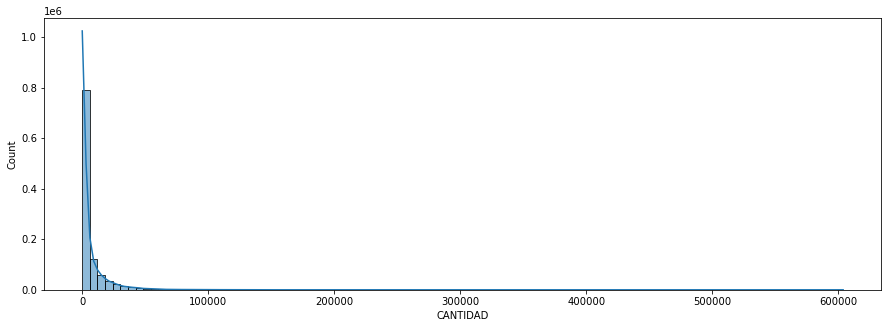

In [13]:
plt.figure(figsize=(15,5))
sns.histplot(data = df,x = "CANTIDAD", kde=True, bins= 100)
plt.show()

In [14]:
df.sort_values(by='CANTIDAD', ascending = False).head()

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR
71387,2020-03-09,SOFSE - Roca,FFCC ROCA,SI,TREN,NACIONAL,JN,SD,603766,NO
72547,2020-03-10,SOFSE - Roca,FFCC ROCA,SI,TREN,NACIONAL,JN,SD,589769,NO
52936,2020-02-21,SOFSE - Roca,FFCC ROCA,SI,TREN,NACIONAL,JN,SD,581110,NO
43114,2020-02-12,SOFSE - Roca,FFCC ROCA,SI,TREN,NACIONAL,JN,SD,580936,NO
50714,2020-02-19,SOFSE - Roca,FFCC ROCA,SI,TREN,NACIONAL,JN,SD,575343,NO


In [15]:
df_sin_trenes = df[df['TIPO_TRANSPORTE'] != 'TREN']
df_sin_trenes.sort_values(by='CANTIDAD', ascending=False).head()

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR
72166,2020-03-09,METROVIAS,LINEA_B,SI,SUBTE,NaN,NaN,NaN,293525,NO
73309,2020-03-10,METROVIAS,LINEA_B,SI,SUBTE,NaN,NaN,NaN,276749,NO
71782,2020-03-09,METROVIAS,LINEA SUBTE D,SI,SUBTE,NaN,NaN,NaN,273728,NO
67785,2020-03-05,METROVIAS,LINEA_B,SI,SUBTE,NaN,NaN,NaN,270199,NO
66639,2020-03-04,METROVIAS,LINEA_B,SI,SUBTE,NaN,NaN,NaN,269048,NO


En cuanto a outliers en ‘CANTIDAD’, tampoco parecen errores. Simplemente trenes y subtes tienen mas cantidad de transacciones por transporte, que es lo normal. Es interesante el dato igualmente, a la hora de calcular estadisticas y medias, quiza se pueda considerar quitar estos transportes del análisis

# 4. Análisis temporal
## 4.1. Viajes a lo largo de los meses

In [16]:
df['año_mes'] = df['DIA_TRANSPORTE'].dt.strftime('%Y-%m')
df.head()

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR,año_mes
0,2020-01-01,EMPRESA BATAN S.A.,BS_AS_LINEA 715M,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,2154,NO,2020-01
1,2020-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,1492,NO,2020-01
2,2020-01-01,EMPRESA DE TRANSPORTE PERALTA RAMOS SACI,BS_AS_LINEA_512,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1889,NO,2020-01
3,2020-01-01,AUTOBUSES BUENOS AIRES S.R.L. – TRANSPORTE LAR...,BS_AS_LINEA_514,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,ALMIRANTE BROWN,4669,NO,2020-01
4,2020-01-01,EL URBANO SRL,BS_AS_LINEA_522,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,LANUS,187,NO,2020-01


A partir de la columna de la fecha, creo una columna nueva que contenga solo el año y el mes. De esta manera puedo agrupar cantidad de viajes por mes.
Con esta columna ploteo la cantidad de viajes a lo largo de los meses:

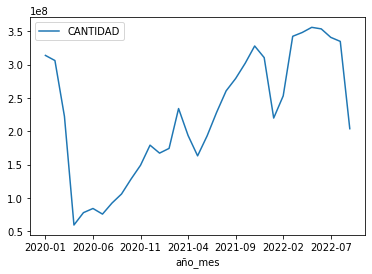

In [17]:
df.groupby(by = 'año_mes').sum().plot(kind = 'line')
plt.show()

Hay una caída importante en septiembre, pero eso no representa la realidad, porque se debe a que el dataset tiene datos hasta mitad de septiembre. Por esta razon quito estas fechas del análisis:

In [18]:
df = df[df['año_mes'] != '2022-09']
group_aniomes = df.groupby(by = 'año_mes').sum().reset_index()
group_aniomes.head()

,año_mes,CANTIDAD
0,2020-01,313754198
1,2020-02,306069353
2,2020-03,222294728
3,2020-04,59187842
4,2020-05,77753791


In [19]:
def format_func(value, tick_number=None):
    num_thousands = 0 if abs(value) < 1000 else floor (log10(abs(value))/3)
    value = round(value / 1000**num_thousands, 2)
    return f'{value:g}'+' KMBTPEZY'[num_thousands]
#Esta funcion convierte la escala logaritmica a un formato legible (ej: 100000000 a 100M)

Ahora con los datos irrelevantes fuera, y la función para formatear los valores y volverlos mas fáciles de leer, vuelvo a plotear la cantidad de viajes a lo largo de los meses. También defino como el comienzo de la cuarentena al mes de abril, que fue el primer mes completo con restricciones. (Realmente las restricciones comenzaron a fin de marzo)

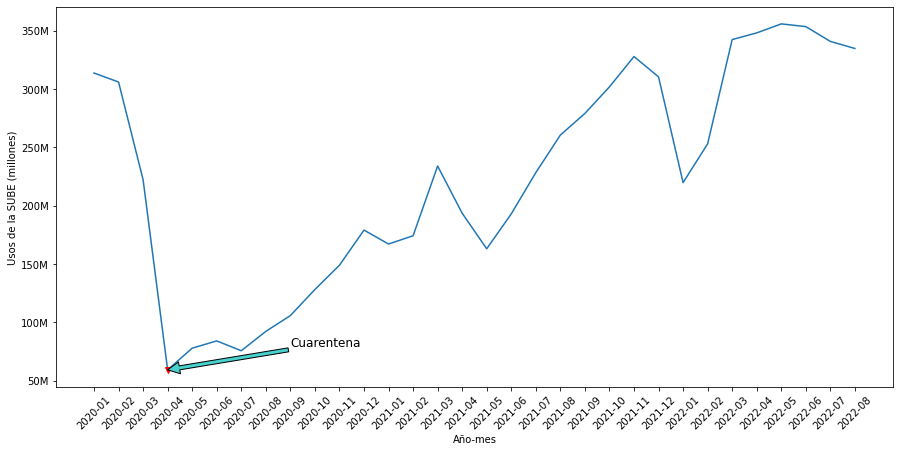

In [20]:
markers_on = [14]
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(group_aniomes["año_mes"], group_aniomes["CANTIDAD"])
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
plt.xticks(rotation=45)
plt.xlabel("Año-mes")
plt.ylabel("Usos de la SUBE (millones)")
plt.plot(group_aniomes["CANTIDAD"].idxmin(), group_aniomes["CANTIDAD"].min(), "v", color = "r")
plt.annotate('Cuarentena', xy = (group_aniomes["CANTIDAD"].idxmin(), group_aniomes["CANTIDAD"].min()),
             fontsize = 12, xytext = (group_aniomes["CANTIDAD"].idxmin() + 5, group_aniomes["CANTIDAD"].min() + 20000000),
             arrowprops = dict(facecolor = 'mediumturquoise'),
             color = 'black')
plt.show()

A primera vista se puede ver una caída importante a principios de 2020. Evidentemente la razón de esta caída es la pandemia. Es interesante como se ve la recuperación progresiva de cantidad de viajes. Podemos concluir que la recuperación de la pandemia en relación a los viajes en transporte público tardó aproximadamente 2 años, e incluso superó los valores de pre-pandémicos.

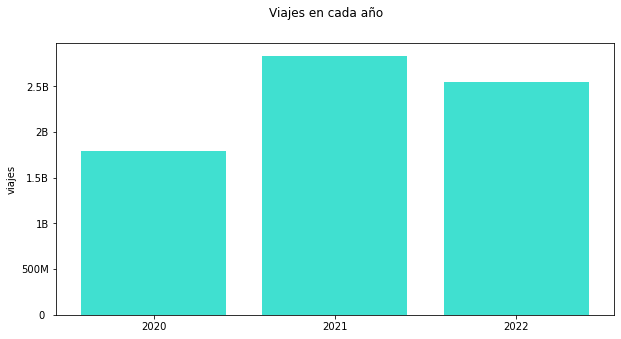

In [21]:
viajes_por_anio = df.groupby(df["DIA_TRANSPORTE"].dt.strftime('%Y'))["CANTIDAD"].agg("sum").reset_index()
viajes_por_anio.rename(columns = {'DIA_TRANSPORTE':'AÑO'}, inplace = True)
fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(viajes_por_anio["AÑO"],viajes_por_anio["CANTIDAD"], color = "turquoise")
ax.set_ylabel("viajes")
fig.suptitle("Viajes en cada año")
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))

Definitivamente, se puede afirmar que la pandemia afectó a la cantidad de viajes en transporte público.

### 4.2. Viajes según el día de la semana
Bajo la hipótesis de que durante el fin de semana, la cantidad de viajes cae, me propongo graficar la cantidad de viajes promedio según el dia de la semana.

In [22]:
df["nombre_dia"] = df["DIA_TRANSPORTE"].dt.strftime("%A")

Al igual que con el mes y año, ahora creo una columna que tenga el dia de la semana (en nombre)

In [23]:
orden = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

crosstab_dia = pd.crosstab(df["nombre_dia"], df["TIPO_TRANSPORTE"], values = df["CANTIDAD"], aggfunc= "mean")
crosstab_dia.drop(["LANCHAS"], axis=1,inplace=True)
#Quito las lanchas del analisis porque sus valores son tan bajos, que se vuelven irrelevantes en el grafico
crosstab = crosstab_dia.astype(int).reindex(orden)#Con esta funcion ordeno el crosstab acorde a los dias de la semana
crosstab

TIPO_TRANSPORTE,COLECTIVO,SUBTE,TREN
nombre_dia,,,
Monday,6541,51713,37036
Tuesday,6948,57359,39458
Wednesday,6905,56446,39043
Thursday,6986,58939,39803
Friday,7046,56244,39389
Saturday,4899,28505,22845
Sunday,2897,14804,9731


Con esta información, ya ordenada, decido hacer un gráfico de barras (multiple) para comprar los viajes en cada día de la semana.

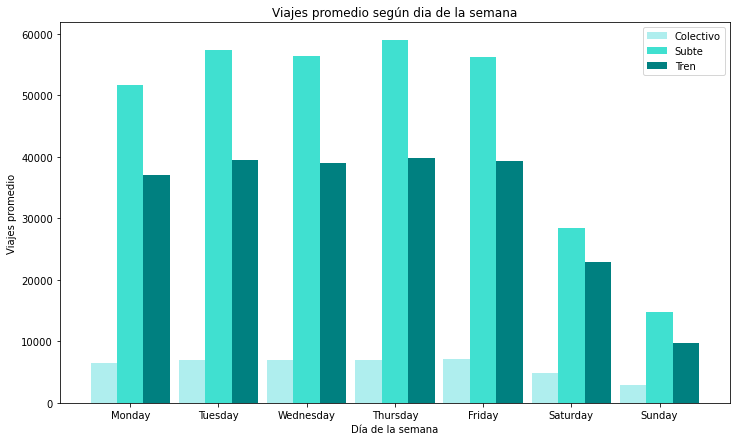

In [24]:
X_axis = np.arange(len(crosstab.index))
width = 0.3

plt.figure(figsize=(12,7))
bar1 = plt.bar(X_axis, crosstab["COLECTIVO"], width, color = "paleturquoise")
bar2 = plt.bar(X_axis + width, crosstab["SUBTE"],width, color = "turquoise")
bar3 = plt.bar(X_axis + width * 2, crosstab["TREN"],width, color = "teal")

plt.xticks(X_axis+width,crosstab.index)
plt.legend( (bar1, bar2, bar3), ('Colectivo', 'Subte', 'Tren') )
plt.title("Viajes promedio según dia de la semana")
plt.xlabel("Día de la semana")
plt.ylabel("Viajes promedio")
plt.show()

Como era esperado, los fines de semana hay una baja en la cantidad de usos del transporte público, siendo el domingo el día con menos viajes. La razón principal es principalmente que menos gente trabaja durante los fines de semana, por lo que se mueve menos en transporte público.
### 4.3. Viaje según semana del año
Al igual que con el dia y el mes-año, creo otra columna, esta vez con la semana del año:

In [25]:
df['dia_semana'] = df['DIA_TRANSPORTE'].dt.strftime('%U')
df_2020 = df[(df["DIA_TRANSPORTE"] >= "2020-1-1") & (df["DIA_TRANSPORTE"] < "2021-1-1")]
df_2021 = df[(df["DIA_TRANSPORTE"] >= "2021-1-1") & (df["DIA_TRANSPORTE"] < "2022-1-1")]
df_2022 = df[(df["DIA_TRANSPORTE"] >= "2022-1-1") & (df["DIA_TRANSPORTE"] < "2023-1-1")]

gr_semana_20 = df_2020.groupby("dia_semana")['CANTIDAD'].agg("sum").reset_index()
gr_semana_21 = df_2021.groupby("dia_semana")['CANTIDAD'].agg("sum").reset_index()
gr_semana_22 = df_2022.groupby("dia_semana")['CANTIDAD'].agg("sum").reset_index()

Como ya había mencionado, el último dataset solo contiene informacion hasta septiembre.
Por lo tanto, si en un gráfico se colocan los 3 años, la escala sería diferente y se volveria mas dificil la comparación.
La solucion para este problema:

In [26]:
sem = list(range(36, 53))
val = [0] * 17

df_aux = pd.DataFrame({"dia_semana":sem,"CANTIDAD":val})
gr_semana_22 = pd.concat([gr_semana_22, df_aux], axis=0, ignore_index=True)
gr_semana_22["dia_semana"] = gr_semana_22["dia_semana"].astype(str)
#Para que los 3 graficos queden de la misma escala en el eje x, agrego las filas faltantes con valores 0

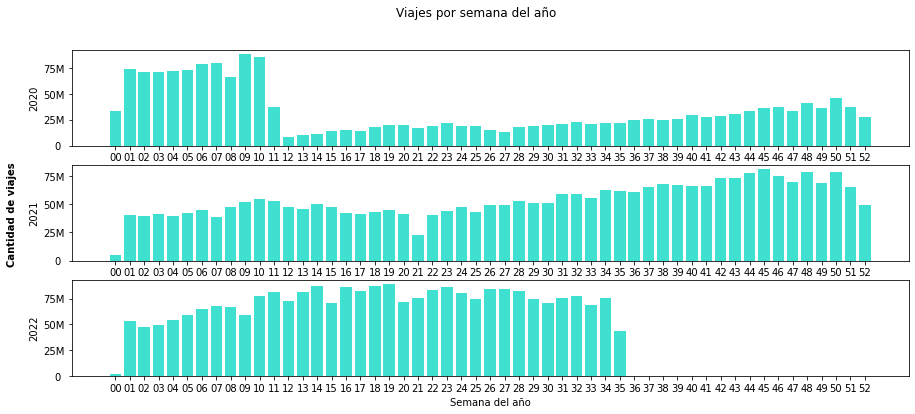

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 6))
ax1.bar(gr_semana_20["dia_semana"], gr_semana_20["CANTIDAD"], color = "turquoise")
ax1.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax2.bar(gr_semana_21["dia_semana"], gr_semana_21["CANTIDAD"], color = "turquoise")
ax2.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax3.bar(gr_semana_22["dia_semana"],gr_semana_22["CANTIDAD"], color = "turquoise")
ax3.yaxis.set_major_formatter(plt.FuncFormatter(format_func))

ax3.set_xlabel("Semana del año")

ax1.set_ylabel("2020")
ax2.set_ylabel("2021")
ax3.set_ylabel("2022")

fig.suptitle("Viajes por semana del año")
fig.text(0.07, 0.5, 'Cantidad de viajes', ha='center', va='center', rotation='vertical', weight = 'bold')
plt.show()

De esta manera se puede ver de manera mas específica el impacto de la cuarentena en los viajes.
Como dato adicional, en los 3 años, en la primer semana del año casi no hay viajes a comparación del resto del año. Posiblemente sea por las fiestas y las vacaciones que muchos se toman durante estos días.

# 5. Análisis según tipo de transporte
Es importante también definir la comparación entre los tipos de transporte.
El análisis se centrará en 3 aspectos: Cantidad de transportes, cantidad de viajes totales y promedio de viajes por transporte. Es decir, el primero es cuantas veces aparece cada transporte en el dataset, el segundo cuantos viajes totales tuvieron estos, y el tercero la división entre ambos.

In [28]:
df_tipo_transporte = df.groupby(['TIPO_TRANSPORTE'])["CANTIDAD"].agg({"count","sum","mean"}).reset_index()
df_tipo_transporte

,TIPO_TRANSPORTE,sum,count,mean
0,COLECTIVO,6281162659,1028399,6107.709808
1,LANCHAS,32790,3616,9.068031
2,SUBTE,335715759,7252,46292.851489
3,TREN,557107756,17003,32765.262365


In [29]:
df_tipo_transporte.drop(df_tipo_transporte.index[1], inplace = True)
#Quito la fila de las Lanchas para plotear. (No representa casi nada en todas las categorias)

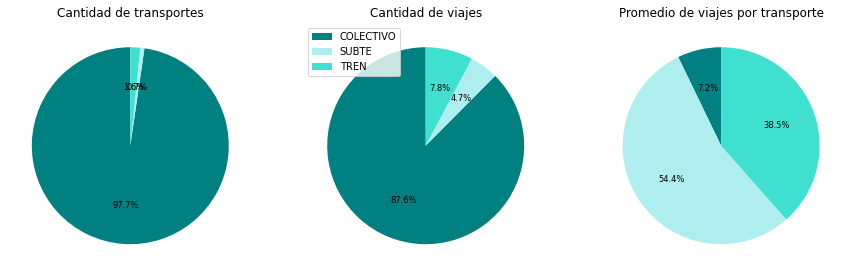

In [30]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].pie(df_tipo_transporte["count"], startangle = 90, autopct='%1.1f%%',textprops={'size': 'smaller'}, colors = ["teal", "paleturquoise","turquoise"])
ax[0].set_title("Cantidad de transportes")
ax[1].pie(df_tipo_transporte["sum"], startangle = 90,autopct='%1.1f%%',textprops={'size': 'smaller'}, colors = ["teal", "paleturquoise","turquoise"])
ax[1].set_title("Cantidad de viajes")
ax[1].legend(df_tipo_transporte["TIPO_TRANSPORTE"], loc='best')
ax[2].pie(df_tipo_transporte["mean"], startangle = 90, autopct='%1.1f%%',textprops={'size': 'smaller'}, colors = ["teal", "paleturquoise","turquoise"])
ax[2].set_title("Promedio de viajes por transporte")

plt.show()

Como es de esperarse, el tipo de transporte del que más hay es el colectivo.
También en cantidad de usos de la SUBE, es decir la gran mayoría de los viajes son en colectivo.
En el caso de transacciones promedio por cada transporte, sin embargo, el subte y tren lideran.

# 6. Análisis geográfico

Con la ayuda de groupbys y la librería de geopandas se representa la cantidad de transacciones según la provincia.
Se marcarán claramente aquellas provincias de las que no haya información.

In [31]:
print(f"Provs en df_SUBE: {df['PROVINCIA'].unique()}\n")
print(f"Provs en geodf: {gdf['nam'].unique()}")

Provs en df_SUBE: ['BUENOS AIRES' 'JN' 'CHUBUT' nan 'LA RIOJA' 'SANTA FE' 'MENDOZA'
 'CORDOBA' 'RÍO NEGRO' 'CHACO' 'NEUQUÉN' 'LA PAMPA' 'ENTRE RÍOS' 'FORMOSA'
 'CORRIENTES' 'CATAMARCA' 'TIERRA DEL FUEGO' 'SAN LUIS' 'SAN JUAN' 'JUJUY']

Provs en geodf: ['Ciudad Autónoma de Buenos Aires' 'Neuquén' 'San Luis' 'Santa Fe'
 'La Rioja' 'Catamarca' 'Tucumán' 'Chaco' 'Formosa' 'Santa Cruz' 'Chubut'
 'Mendoza' 'Córdoba' 'Entre Ríos' 'San Juan' 'Jujuy' 'Santiago del Estero'
 'Río Negro' 'Corrientes' 'Misiones' 'Salta' 'La Pampa' 'Buenos Aires']


En el dataset de las transacciones faltan las provincias de Salta, Tucumán, Santiago del Estero, Misiones y Santa Cruz.
Este dato es importante porque a la hora de graficar en el mapa habrá provincias sin datos.

### 6.1. Groupby: Viajes por provincia

In [32]:
transacciones_por_prov = df.groupby("PROVINCIA")["CANTIDAD"].sum().reset_index().sort_values(by = "PROVINCIA")
transacciones_por_prov["PROVINCIA"] = transacciones_por_prov["PROVINCIA"].str.title()
transacciones_por_prov.head()

,PROVINCIA,CANTIDAD
0,Buenos Aires,2999063108
1,Catamarca,29516207
2,Chaco,44159914
3,Chubut,35273993
4,Cordoba,54293


Ahora se mergean ambos: El dataset con los limites provinciales y el groupby (transacciones_por_prov) con la cantidad de transacciones por provincia. De esa manera se puede distinguir en el mapa visualemente que provincia tienes mas transacciones.

### 6.2. Merge
Se mergearán los dataframes con la columna de los nombres de las provincias.

In [33]:
gdf_bs = gdf.drop(gdf.index[0]).sort_values(by = "nam")
gdf_bs['nam'] = gdf_bs['nam'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
transacciones_por_prov['PROVINCIA'] = transacciones_por_prov['PROVINCIA'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
# Se quitan los acentos para que el merge entre ambos no tenga errores

In [34]:
gdf_bs = gdf_bs.merge(transacciones_por_prov, left_on="nam", right_on="PROVINCIA", how = "left")
gdf_bs.drop(["PROVINCIA", "geometry"], axis=1, inplace=True)
gs2 = gpd.GeoSeries.from_wkt(gdf_bs["geom"])
gpd.GeoDataFrame(gdf_bs, geometry=gs2, crs = "EPSG:4326").head()
#A traves del merge cada provincia tiene su cantidad de transacciones

,gid,entidad,objeto,geom,fna,gna,nam,in1,fdc,sag,CANTIDAD,geometry
0,24,0,Provincia,"MULTIPOLYGON(((-62.153392792 -40.45148468,-62....",Provincia de Buenos Aires,Provincia,Buenos Aires,6,Geografía,IGN,2.999063e+09,"MULTIPOLYGON (((-62.15339 -40.45148, -62.15339..."
1,6,0,Provincia,"MULTIPOLYGON(((-66.099756973 -26.220485676,-66...",Provincia de Catamarca,Provincia,Catamarca,10,Geografía,IGN,2.951621e+07,"MULTIPOLYGON (((-66.09976 -26.22049, -66.10088..."
2,8,0,Provincia,"MULTIPOLYGON(((-58.377351007 -26.872232293,-58...",Provincia del Chaco,Provincia,Chaco,22,Geografía,IGN,4.415991e+07,"MULTIPOLYGON (((-58.37735 -26.87223, -58.37764..."
3,11,0,Provincia,MULTIPOLYGON(((-70.990680431 -41.9999644609999...,Provincia del Chubut,Provincia,Chubut,26,Geografía,IGN,3.527399e+07,"MULTIPOLYGON (((-70.99068 -41.99996, -70.20898..."
4,19,0,Provincia,"MULTIPOLYGON(((-57.970989286 -27.274986108,-57...",Provincia de Corrientes,Provincia,Corrientes,18,Geografía,IGN,4.617757e+07,"MULTIPOLYGON (((-57.97099 -27.27499, -57.96509..."


### 6.3. Plot del mapa

Sabemos que la provincia con mas viajes es Buenos Aires, por lo que se harán dos gráficos con el objetivo de poder ver bien el contraste entre las demás provincias también.

In [35]:
gdf_sin_bs = gdf_bs.iloc[1:] #dataframe sin la provincia de Bs. As.

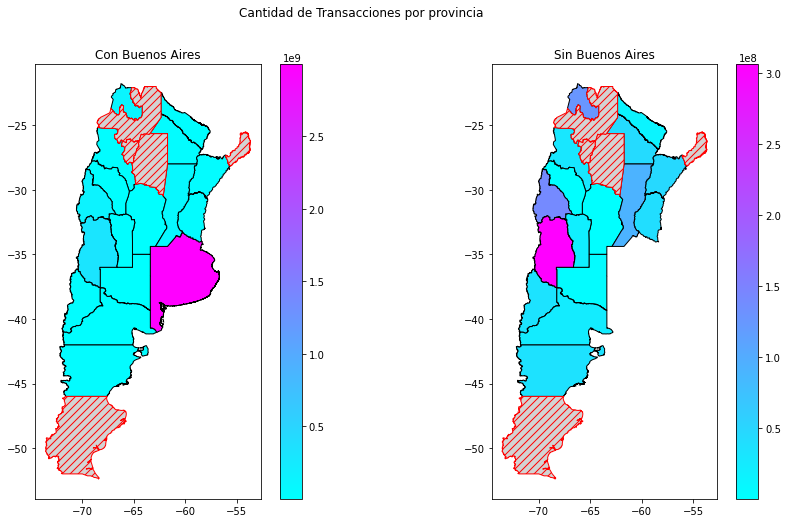

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
gdf_bs.plot(ax=ax1, column = "CANTIDAD", cmap = "cool", legend = True, edgecolor='black',
            missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Missing values",
    })
gdf_sin_bs.plot(ax=ax2, column = "CANTIDAD", cmap = "cool", legend = True, edgecolor='black',
                missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Missing values",
    })
ax1.set_title("Con Buenos Aires")
ax2.set_title("Sin Buenos Aires")
fig.suptitle('Cantidad de Transacciones por provincia')
plt.show()

Lógicamente, Buenos Aires es con diferencia la provincia con mas viajes.
Seguida de Mendoza, San Juan, Jujuy y Santa Fe, que, exceptuando San Juan, son a mi parecer resultados lógicos.

En mi opinión sorprende San Juan, de la que esperaba menos viajes, y Córdoba, de la que creía que iba a estar entre las 5 provincias con mas transacciones y se encuentra entre las últimas.

### 6.4. Viajes en AMBA

Al ser Buenos Aires la zona mas importante, se hará un análisis un poco mas profundo a cerca de esta provincia:

In [37]:
gr_amba = df.groupby("AMBA")["CANTIDAD"].agg("sum")

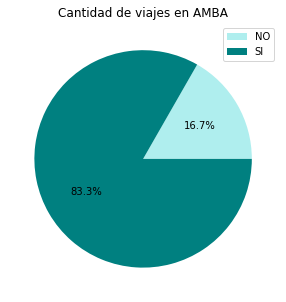

In [38]:
plt.figure(figsize=(10,5))
plt.pie(gr_amba, autopct="%1.1f%%", colors = ["paleturquoise", "teal"])
plt.title("Cantidad de viajes en AMBA")
plt.legend(gr_amba.index, loc='best')
plt.show()

Definitivamente el AMBA es la zona mas transitada del país, concentrando el 83,2% de las transacciones.
#### Municipios ####
Al ser Buenos Aires y el AMBA la región mas importante en cuanto a viajes, parece importante definir que localidades son las más importantes también.

In [39]:
df_buenos_aires = df[(df["PROVINCIA"] == "BUENOS AIRES") & (df["JURISDICCION"] == "MUNICIPAL")]
gr_bs_as = df_buenos_aires.groupby("MUNICIPIO")["CANTIDAD"].agg("sum").sort_values(ascending = False).iloc[:10].reset_index()

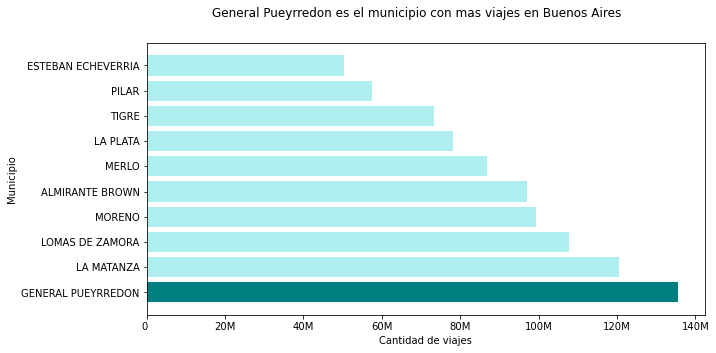

In [40]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.barh(gr_bs_as["MUNICIPIO"], gr_bs_as["CANTIDAD"])
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
fig.suptitle("General Pueyrredon es el municipio con mas viajes en Buenos Aires")
ax.set_xlabel("Cantidad de viajes")
ax.set_ylabel("Municipio")
ax.patches[0].set_facecolor('teal')
for i in ax.patches[1:]:
    i.set_facecolor('paleturquoise')
plt.show()

# 7. Modelo de usos a lo largo de la cuarentena
El modelo intenta inferir la cantidad de usos/ transferencias de la SUBE, según en que día de la cuarentena se encuentra.
Se parte de la hipótesis de que hay una correlación positiva entre los dias desde el comienzo de la pandemia y la cantidad de transacciones, es decir, que a medida que avanza la cuarentena, también aumentan los viajes.
Se harán dos modelos, ambos sobre el subte: Uno de todas las lineas (general) y uno solo sobre la línea del premetro (específico), con el objetivo de comparar la efectividad entre ambos.

### 7.1. Modelo general

In [41]:
df_subte_en_pandemia = df[(df["TIPO_TRANSPORTE"] == "SUBTE") & (df["DIA_TRANSPORTE"] >= "2020-04-01")]
#Se toma como inicio de la cuarentena el 1 de abril de 2020

In [42]:
df_subte_en_pandemia["dia_numero"] = df_subte_en_pandemia['DIA_TRANSPORTE'].map(dt.datetime.toordinal) - 737515
df_subte_en_pandemia.head()

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR,año_mes,nombre_dia,dia_semana,dia_numero
94753,2020-04-01,METROVIAS,LIN_PREMETRO,SI,SUBTE,NaN,NaN,NaN,238,NO,2020-04,Wednesday,13,1
95004,2020-04-01,METROVIAS,LINEA SUBTE C,SI,SUBTE,NaN,NaN,NaN,4661,NO,2020-04,Wednesday,13,1
95005,2020-04-01,METROVIAS,LINEA SUBTE D,SI,SUBTE,NaN,NaN,NaN,4149,NO,2020-04,Wednesday,13,1
95006,2020-04-01,METROVIAS,LINEA SUBTE E,SI,SUBTE,NaN,NaN,NaN,1705,NO,2020-04,Wednesday,13,1
95007,2020-04-01,METROVIAS,LINEA SUBTE H,SI,SUBTE,NaN,NaN,NaN,3335,NO,2020-04,Wednesday,13,1


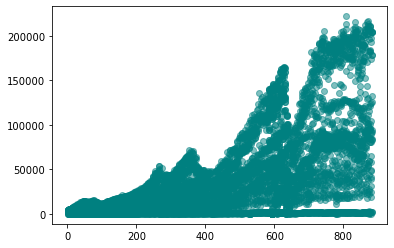

In [43]:
plt.scatter(df_subte_en_pandemia["dia_numero"], df_subte_en_pandemia["CANTIDAD"], alpha= 0.5, color = "teal")
plt.show()

In [44]:
model_data = df_subte_en_pandemia[["dia_numero", "CANTIDAD"]]

X = model_data[["dia_numero"]]
y = model_data["CANTIDAD"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [45]:
model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

### 7.2. Modelo Premetro

In [46]:
df_premetro = df[(df["TIPO_TRANSPORTE"] == "SUBTE") & (df["LINEA"] == "LIN_PREMETRO") & (df["DIA_TRANSPORTE"] >= "2020-04-01")]
df_premetro["dia_numero"] = df_premetro['DIA_TRANSPORTE'].map(dt.datetime.toordinal) - 737515
df_premetro.head()

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR,año_mes,nombre_dia,dia_semana,dia_numero
94753,2020-04-01,METROVIAS,LIN_PREMETRO,SI,SUBTE,NaN,NaN,NaN,238,NO,2020-04,Wednesday,13,1
95724,2020-04-02,METROVIAS,LIN_PREMETRO,SI,SUBTE,NaN,NaN,NaN,263,NO,2020-04,Thursday,13,2
96695,2020-04-03,METROVIAS,LIN_PREMETRO,SI,SUBTE,NaN,NaN,NaN,303,NO,2020-04,Friday,13,3
97664,2020-04-04,METROVIAS,LIN_PREMETRO,SI,SUBTE,NaN,NaN,NaN,178,NO,2020-04,Saturday,13,4
98624,2020-04-05,METROVIAS,LIN_PREMETRO,SI,SUBTE,NaN,NaN,NaN,102,NO,2020-04,Sunday,14,5


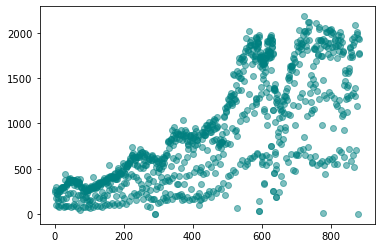

In [47]:
plt.scatter(df_premetro["dia_numero"], df_premetro["CANTIDAD"], alpha = 0.5, color = "teal")
plt.show()

In [48]:
model_data_prem = df_premetro[["dia_numero", "CANTIDAD"]]

X_prem = model_data_prem[["dia_numero"]]
y_prem = model_data_prem["CANTIDAD"]

X_train_prem, X_test_prem, y_train_prem, y_test_prem = train_test_split(X_prem, y_prem, test_size=0.25)

In [49]:
model_prem = LinearRegression()

model_prem.fit(X_train_prem, y_train_prem)

y_pred_prem = model_prem.predict(X_test_prem)

### 7.3. Plot modelos

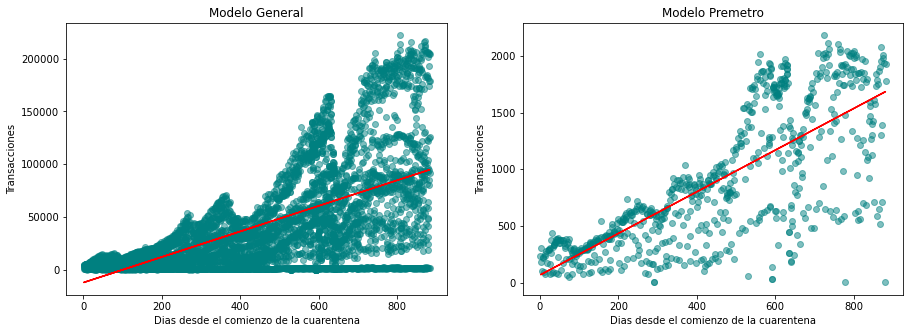

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
#Modelo General
ax1.scatter(X_train, y_train, color = "teal", alpha= 0.5)
ax1.plot(X_test.values, y_pred, color = "r")
ax1.set_xlabel("Dias desde el comienzo de la cuarentena")
ax1.set_ylabel("Transacciones")
ax1.set_title("Modelo General")

#Modelo Premetro
ax2.scatter(X_train_prem, y_train_prem, color = "teal", alpha= 0.5)
ax2.plot(X_test_prem.values, y_pred_prem, color = "r")
ax2.set_xlabel("Dias desde el comienzo de la cuarentena")
ax2.set_ylabel("Transacciones")
ax2.set_title("Modelo Premetro")

plt.show()

# 7.4. Predicciones
Una vez que hicimos los modelos, podemos utilizarlos para estimar los viajes segun el dia.
En palabras simples, cuando se pasemos un dia x, incluso uno inexistente (como 500.5), el modelo devolverá el valor que mejor se ajuste a todos los datos. En definitiva le pasamos un valor x y nos devuelve el valor y de la función lineal que modeló:
#### Modelo General ####

In [51]:
print(f"A los 300 dias de cuarentena: {int(model.predict([[300]])[0])} transacciones")
print(f"A los 500.5 dias de cuarentena: {int(model.predict([[500.5]])[0])} transacciones")
print(f"A los 700 dias de cuarentena: {int(model.predict([[700]])[0])} transacciones")

A los 300 dias de cuarentena: 24043 transacciones
A los 500.5 dias de cuarentena: 48324 transacciones
A los 700 dias de cuarentena: 72484 transacciones


#### Modelo Premetro ####

In [52]:
print(f"A los 300 dias de cuarentena: {int(model_prem.predict([[300]])[0])} transacciones")
print(f"A los 500.5 dias de cuarentena: {int(model_prem.predict([[500.5]])[0])} transacciones")
print(f"A los 700 dias de cuarentena: {int(model_prem.predict([[700]])[0])} transacciones")

A los 300 dias de cuarentena: 617 transacciones
A los 500.5 dias de cuarentena: 985 transacciones
A los 700 dias de cuarentena: 1352 transacciones


### 7.5. Evaluación del modelo

In [53]:
from sklearn import metrics

print(f"MAE: {round(metrics.mean_absolute_error(y_test, y_pred),2)}")
print(f"RMSE: {round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),2)}")
print(f"R2: {round(metrics.r2_score(y_test, y_pred),2)}")
print(f"MAPE: {round(metrics.mean_absolute_percentage_error(y_test, y_pred),2)}")

MAE: 27758.75
RMSE: 38582.41
R2: 0.37
MAPE: 90.86


In [54]:
print(f"MAE: {round(metrics.mean_absolute_error(y_test_prem, y_pred_prem),2)}")
print(f"RMSE: {round(np.sqrt(metrics.mean_squared_error(y_test_prem, y_pred_prem)),2)}")
print(f"R2: {round(metrics.r2_score(y_test_prem, y_pred_prem),2)}")
print(f"MAPE: {round(metrics.mean_absolute_percentage_error(y_test_prem, y_pred_prem),2)}")

MAE: 309.35
RMSE: 398.44
R2: 0.59
MAPE: 0.6


Todas la métricas dan a favor del modelo del premetro, por lo que podemos concluir que este es un modelo mas eficiente a la hora de predecir la cantidad de viajes.
Tiene un MAE (error absoluto medio) y RMSE (error cuadratico medio) menor. El MAE calcula la diferencia absoluta entre los valores reales y los valores pronosticados. El RMSE hace algo similar, representa a la raíz cuadrada de la distancia cuadrada promedio entre el valor real y el valor pronosticado. Cuanto mas grandes son estas metricas, peor es el modelo.
El R2 (coeficiente de determinación) es mas grande en el caso del premetro, y en este caso es algo positivo. El R2 evalúa la fuerza de la relación lineal entre dos variables. Cuanto mas cercana sea a 1, mejor.
El MAPE (Error de porcentaje medio absoluto) se asemeja a las primeras 2 metricas. También cuanto mas bajo sea, mejor es el modelo. Sin embargo, esta métrica suele aumentar de más cuando toma valores cercanos a 0 (como en este caso), por lo que posiblemente no sea la mejor métrica para evaluar este modelo.


# 8 Conclusiones
En relación a los primeros insights, era de esperarse que Buenos Aires sea la región con mas viajes. También es logico que la mayoria de los usos de la SUBE se concentren en el colectivo, teniendo en cuenta que es el unico transporte presente en todas provincias.
En cuanto al modelo, se cumple la hipotesis inicial: A medida que avanzó la cuarentena efectivamente aumentaron los viajes en transporte publico. Incluso el modelo mas general, si bien es menos preciso, demostro que hay una correlacion positiva entre dias de cuarentena y viajes. Las razones pueden ser muchas: Levantamiento de restricciones, vuelta a clases/ trabajo, pérdida de miedo de la sociedad hacia el coronavirus, vacunación, etc.